In [2]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U seaborn --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
df = pd.read_csv("/content/twitter_multi_class_sentiment.csv")


In [4]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


,0
text,0
label,0
label_name,0


In [6]:
df["label"].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


## Analysis

In [8]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'frequency of classes')

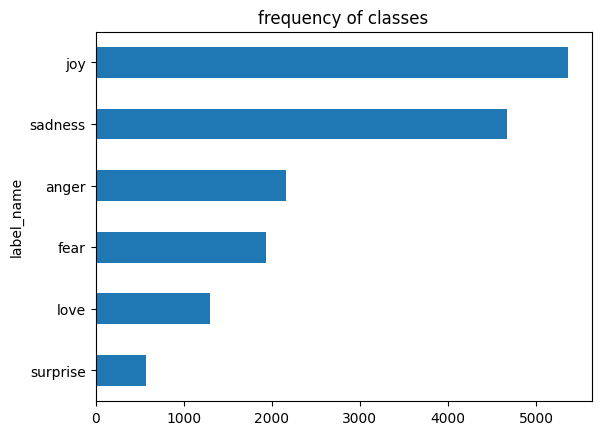

In [11]:
label_counts = df["label_name"].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("frequency of classes")

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

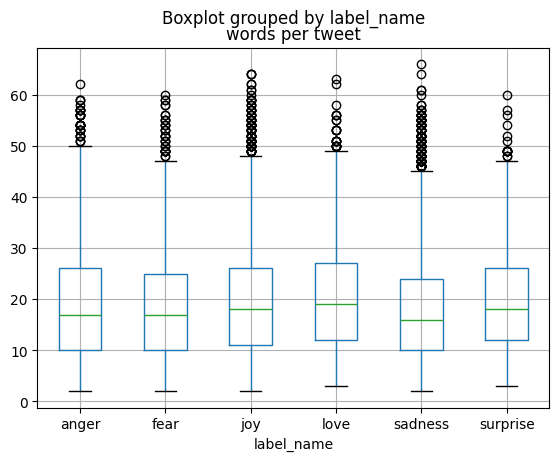

In [13]:
df["words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("words per tweet", by = "label_name")

## Text To Tokens

In [16]:
from transformers import AutoTokenizer
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = "I love Machine Learning! Tokenization is Awesome!"
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

## Data Loader and Train Test Split

In [87]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df, test_size = 0.3, stratify=df["label_name"])
test,validation = train_test_split(test, test_size = 1/3, stratify=test["label_name"])

train.shape, test.shape,validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [88]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
    "train" : Dataset.from_pandas(train, preserve_index=False),
    "test" : Dataset.from_pandas(test, preserve_index=False),
    "validation" : Dataset.from_pandas(validation, preserve_index=False)
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 1600
    })
})

## Tokenization of the Emotions/sentiment Data

In [89]:
dataset["train"][0]

{'text': 'i feel unhappy it is no help for me that other persons say that i am happy how much truth there may be in it',
 'label': 0,
 'label_name': 'sadness',
 'words per tweet': 25}

In [90]:
def tokenize(batch):
  temp = tokenizer(batch["text"], padding =True, truncation = True)
  return temp

tokenize(dataset["train"][:2])

{'input_ids': [[101, 1045, 2514, 12511, 2009, 2003, 2053, 2393, 2005, 2033, 2008, 2060, 5381, 2360, 2008, 1045, 2572, 3407, 2129, 2172, 3606, 2045, 2089, 2022, 1999, 2009, 102], [101, 1045, 2001, 3110, 9191, 2043, 1045, 4149, 2009, 1998, 4415, 2043, 1045, 2001, 2725, 2026, 5789, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [91]:
emotion_encoded = dataset.map(tokenize, batched = True, batch_size = None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [92]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [93]:
label2id = {x["label_name"]:x["label"] for x in dataset["train"]}
id2label = {v:k for k,v in label2id.items()}

print(label2id)
print(id2label)

{'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2}
{0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'}


## Model Building

In [94]:
from transformers import AutoModel
import torch

In [95]:
model = AutoModel.from_pretrained(model_ckpt)

In [96]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [97]:
model.config.architectures

['BertForMaskedLM']

In [98]:
model.config.bad_words_ids

In [99]:
model.config.cross_attention_hidden_size

In [100]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [101]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.56.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [102]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id = label2id, id2label = id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config = config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [103]:
device

device(type='cuda')

In [104]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [105]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.56.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [106]:
from transformers import TrainingArguments
batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate = 2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay = 0.01,
    # evaluation_strategy='epoch',
    disable_tqdm=False
)



In [107]:
!pip install evaluate

In [108]:
import evaluate
import numpy as np
accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
  predictions,labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions = predictions, references = labels)

In [109]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}


In [110]:
from transformers import Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotion_encoded["train"],
    eval_dataset = emotion_encoded["validation"],
    tokenizer = tokenizer
)

/tmp/ipython-input-210606325.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [111]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=350, training_loss=0.6765669904436384, metrics={'train_runtime': 330.7594, 'train_samples_per_second': 67.723, 'train_steps_per_second': 1.058, 'total_flos': 1001502421516800.0, 'train_loss': 0.6765669904436384, 'epoch': 2.0})

In [112]:
preds_output = trainer.predict(emotion_encoded["test"])
preds_output.metrics

{'test_loss': 0.27087122201919556,
 'test_accuracy': 0.9125,
 'test_f1': 0.9128917051339452,
 'test_runtime': 13.0639,
 'test_samples_per_second': 244.951,
 'test_steps_per_second': 3.827}

In [113]:
y_pred = np.argmax(preds_output.predictions, axis = 1)
y_true = emotion_encoded["test"][:]["label"]

In [114]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       933
           1       0.94      0.91      0.93      1072
           2       0.79      0.83      0.81       261
           3       0.92      0.91      0.92       432
           4       0.90      0.88      0.89       387
           5       0.76      0.86      0.81       115

    accuracy                           0.91      3200
   macro avg       0.88      0.89      0.88      3200
weighted avg       0.91      0.91      0.91      3200



In [115]:
label2id

{'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2}

In [116]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

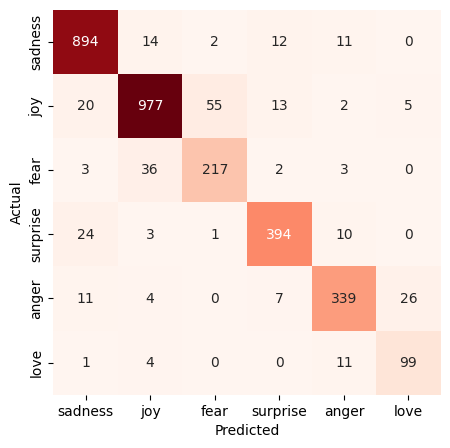

In [117]:
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt = "d", cbar=False, cmap="Reds")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [118]:
text = "I am super happy today."
def get_prediction(text):
  input_encoded = tokenizer(text, return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = model(**input_encoded)

  logits = outputs.logits
  pred = torch.argmax(logits, dim=1).item()
  return id2label[pred]
get_prediction(text)

'joy'

In [119]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
!cp -r /content/bert-base-uncased-sentiment-model /content/drive/MyDrive/

In [122]:
from transformers import pipeline
classifier = pipeline(
    "text-classification",
    model = "bert-base-uncased-sentiment-model"
)
classifier(text + "hello! what a surprise!")

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9653453826904297}]